# Project: Web Traffic Forecasting


In [1]:
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd

from edward.models import Normal, Laplace, PointMass

In [2]:
%matplotlib inline

## Data

In [14]:
df = pd.read_csv("./data/example_wp_peyton_manning.csv")
df["y"] = np.log(df["y"])
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


## Model

In [17]:
# Preprocess Data

def scale(df):
    # Adds a time index t and y_scaled
    df['y'] = pd.to_numeric(df['y'])
    if np.isinf(df['y'].values).any():
        raise ValueError("Found infinity in column y")
        
    df['ds'] = pd.to_datetime(df['ds'])
    if df['ds'].isnull().any():
        raise ValueError("Found Nan in column ds")
    
    df = df.sort_values('ds')
    df.reset_index(inplace=True, drop=True)
    
    # Scale ds and y
    start = df['ds'].min()
    t_scale = df['ds'].max() - start
    df['t'] = (df['ds'] - start) / t_scale
    df['y_scaled'] = df['y'] / df['y'].max()
    return df
                      
def fourier_series(dates, period, order):
    # to days since epoch
    t = np.array((dates - pd.datetime(1970, 1, 1))
                 .dt.total_seconds()
                 .astype(np.float)) / (3600 * 24.0)
    return np.column_stack([
        fun((2.0 * (i + 1) * np.pi * t / period))
        for i in range(order)
        for fun in (np.sin, np.cos)
    ])
    
def seasonal_feature(dates, period, fourier_order, name):
    features = fourier_series(dates, period, fourier_order)
    columns = ['{}_{}'.format(name, i + 1) for i in range(features.shape[1])]
    return pd.DataFrame(features, columns=columns)
    
def make_seasonality_features(history, prior_scale=10.0):
    start = history['ds'].min()
    end = history['ds'].max()
    dt = history['ds'].diff()
    min_dt = dt.iloc[dt.nonzero()[0]].min() # spacing

    seasonal_features = []
    prior_scales = []
    
    # Year seasonality
    yearly_disable = end - start < pd.Timedelta(days=730)
    if not yearly_disable:
        features = seasonal_feature(history['ds'],
                                    period=365.25,
                                    fourier_order=10,
                                    name='yearly')
        seasonal_features.append(features)
        prior_scales.extend([prior_scale] * features.shape[1])
        
    
    # Weekly seasonality
    weekly_disable = ((end - start < pd.Timedelta(weeks=2)) or
                      (min_dt >= pd.Timedelta(weeks=1)))
    if not weekly_disable:
        features = seasonal_feature(history['ds'],
                                    period=7,
                                    fourier_order=3,
                                    name='weekly')
        seasonal_features.append(features)
        prior_scales.extend([prior_scale] * features.shape[1])
        
    # TODO: holiday
    if len(seasonal_features) == 0:
        seasonal_features.append(
            pd.DataFrame({'zeros': np.zeros(history.shape[0])})
        )
        prior_scales.append(1.0)
    return pd.concat(seasonal_features, axis=1), prior_scales



def get_changepoints(history, n_changepoints=-1):
    # Place potential changepoints evenly through first 80% of history
    # Return changepoints_t in t index
    
    hist_size = np.floor(history.shape[0] * 0.8)
    if n_changepoints == -1 or n_changepoints + 1 > hist_size:
        n_changepoints = hist_size - 1
            
    # set changepoints in df['ds'] timestamps
    if n_changepoints == 0:
        changepoints = [] # no changepoints
    else:
        cp_indexes = (
            np.linspace(0, hist_size, n_changepoints + 1)
            .round()
            .astype(np.int)
        )
        changepoints = history.iloc[cp_indexes]['ds'].tail(-1)
    
    # set changepoints_t in t index
    if len(changepoints) > 0:
        start = history['ds'].min()
        t_scale = history['ds'].max() - start
        changepoints_t = np.sort(np.array((changepoints - start) / t_scale))
    else:
        changepoints_t = np.array([0])  # dummy changepoint
      
    # set matrix 
    A = np.zeros((history.shape[0], len(changepoints_t)))
    for i, t_i in enumerate(changepoints_t):
        A[history['t'].values >= t_i, i] = 1
        
    return changepoints_t, A 
    
def preprocess(df):
    # Remove null points
    history = df[df['y'].notnull()].copy()
    
    # Adds a time index and scales y
    history = scale(history)
    print("After scaling: %d\n" % history.shape[0], history.head())
    print()
    
    # Add seasonality features
    seasonal_features, prior_scales = make_seasonality_features(history)
    print("Seasonal_features: %d\n" % len(prior_scales))
    print(seasonal_features.columns)
    print()
    
    # Add changepoints (-1==auto)
    changepoints_t, A = get_changepoints(history, n_changepoints=-1)
    print("Changepoints: %d" % len(changepoints_t))
    
    changepoint_prior_scale=0.05
    data = {
        'T': history.shape[0],
        'K': seasonal_features.shape[1],
        'S': len(changepoints_t),
        'y': history['y_scaled'],
        't': history['t'],
        'A': A,
        't_change': changepoints_t,
        'X': seasonal_features,
        'sigmas': prior_scales,
        'tau': changepoint_prior_scale,
    }
    return data

In [18]:
# Model

data = preprocess(df)
T = data['T']
S = data['S']
K = data['K']

t = tf.placeholder(tf.float32, shape=(T,), name="t")        # time index
A = tf.placeholder(tf.float32, shape=(T, S), name="A")      # changepoint indicators
t_change = tf.placeholder(tf.float32, shape=(S), name="t_change") # changepoints_t
X = tf.placeholder(tf.float32, shape=(T, K), name="X")      # season vectors
sigmas = tf.placeholder(tf.float32, shape=(K,), name="sigmas")  # scale on seasonality prior
tau = tf.placeholder(tf.float32, shape=(), name="tau")      # scale on changepoints prior
       
    
k = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))           # initial slope
m = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))           # initial intercept
sigma_obs = Normal(loc=tf.zeros(1), scale=0.5*tf.ones(1))   # noise
    
delta = Laplace(loc=tf.zeros(S), scale=tau*tf.ones(S))      # changepoint rate adjustment
gamma = tf.multiply(-t_change, delta, name="gamma")

beta = Normal(loc=tf.zeros(K), scale=sigmas*tf.ones(K))     # seasonal
    
y = Normal(loc = (k * tf.ones(T) + ed.dot(A, delta)) * t 
           + m * tf.ones(T) + ed.dot(A, gamma)
           + ed.dot(X, beta),
           scale = sigma_obs * tf.ones(T))

After scaling: 2905
           ds         y         t  y_scaled
0 2007-12-10  9.590761  0.000000  0.746552
1 2007-12-11  8.519590  0.000337  0.663171
2 2007-12-12  8.183677  0.000675  0.637023
3 2007-12-13  8.072467  0.001012  0.628367
4 2007-12-14  7.893572  0.001350  0.614441

Seasonal_features: 26

Index(['yearly_1', 'yearly_2', 'yearly_3', 'yearly_4', 'yearly_5', 'yearly_6',
       'yearly_7', 'yearly_8', 'yearly_9', 'yearly_10', 'yearly_11',
       'yearly_12', 'yearly_13', 'yearly_14', 'yearly_15', 'yearly_16',
       'yearly_17', 'yearly_18', 'yearly_19', 'yearly_20', 'weekly_1',
       'weekly_2', 'weekly_3', 'weekly_4', 'weekly_5', 'weekly_6'],
      dtype='object')

Changepoints: 2323


/home/amy/Documents/Courses/Fall2017/Model/workspace/lib/python3.5/site-packages/ipykernel_launcher.py:93: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [19]:
# Inference

#inference = ed.MAP({k: qk, m: qm, simga_obs: qsimga_obs, beta: qbeta}, 
#                    data={y: data['y'], t: data['t'], A: data['A'], t_change: data['t_change'],
#                          X: data['X'], sigmas: data['sigmas'], tau: data['tau']})

#inference.run(n_iteration=1000)


# Facebook Prophet

In [7]:
from fbprophet import Prophet

# Facebook Prophet
df = pd.read_csv("./data/example_wp_peyton_manning.csv")
df["y"] = np.log(df["y"])
df.head()
m_pp = Prophet()
m_pp.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
future = m_pp.make_future_dataframe(periods=365)
future.tail()
forecast = m_pp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206753,7.513565,8.876372
3266,2017-01-16,8.531766,7.781961,9.303070
3267,2017-01-17,8.319156,7.592930,9.034602
3268,2017-01-18,8.151772,7.431624,8.862139
3269,2017-01-19,8.163690,7.472244,8.884304


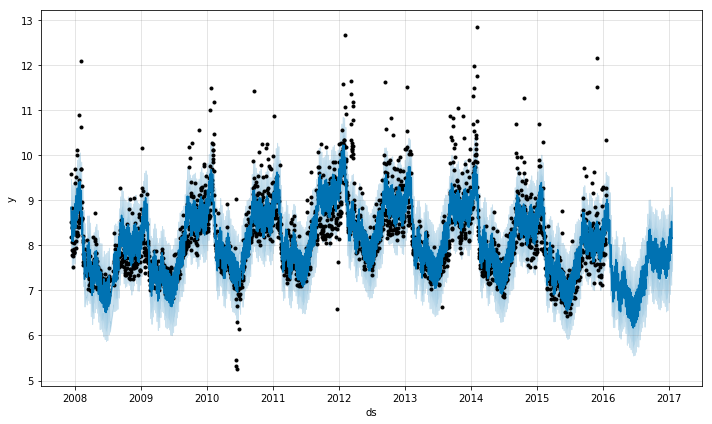

In [9]:
m_pp.plot(forecast);

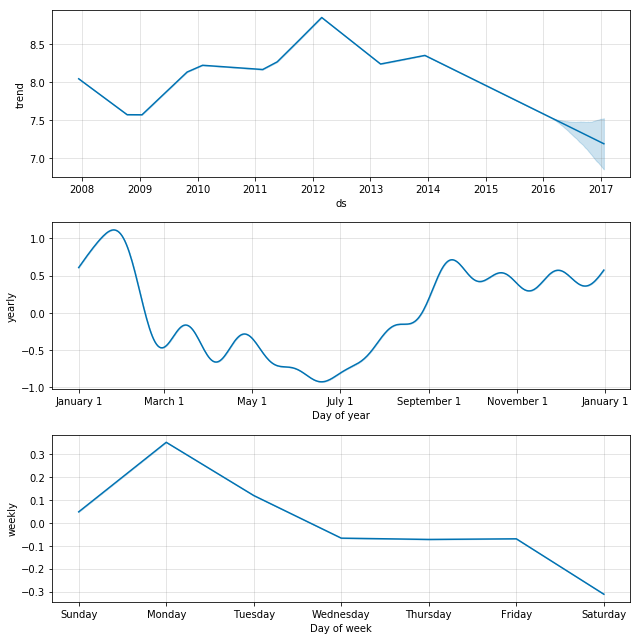

In [10]:
m_pp.plot_components(forecast);